In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [109]:
def greedy(q_t, bandit, num_arms, eps):
    # explore with probability eps
    if np.random.uniform(0, 1) < eps:
        arm = round(np.random.uniform(0, num_arms-1))
    # greedily choose otherwise
    else:
        arm = np.argmax(q_t[bandit,:])
        
    return arm

In [110]:
def n_armed_bandit_greedy(num_bandits, num_arms, num_steps, eps_array = [ 0, 0.01, 0.1 ], sigma = 1.0):

    # global initializations
    q_star_means = np.random.randn(num_bandits, num_arms)

    q_t0 = np.random.normal( q_star_means )

    avg_reward  = np.zeros((len(eps_array),num_steps))
    percent_optimal_action = np.zeros((len(eps_array),num_steps))
    cumulative_rewards    = np.zeros((len(eps_array),num_steps))
    cumulative_probs      = np.zeros((len(eps_array),num_steps))

    for ei, eps in enumerate(eps_array): #pick an epsilon
        # initializations for each eps
        q_t = np.zeros((q_t0.shape));  # <- initialize to zero draws per arm (no knowledge)
        q_n = np.ones(( num_bandits, num_arms )); # keep track of the number draws on each arm 
        q_s = q_t; # keep track of the SUM of the rewards to calculate average later via q_t = q_s./q_n
        all_rewards      = np.zeros((num_bandits, num_steps)); # going to store each of the rewards here
        picked_max_action = np.zeros((num_bandits, num_steps));  # records whether best arm was chosen

        # explore each of the bandits, all with n-arms
        for bandit in range(num_bandits): # pick a bandit
            for step in range(num_steps):
                
                # eps-greedily choose the arm
                arm = greedy(q_t, bandit, num_arms, eps)


                # the best arm for this bandit from the given q_star_means
                best_arm = np.argmax(q_star_means[bandit, :])

                # record whether the best arm was chosen
                if arm == best_arm:
                    picked_max_action[bandit, step] = 1

                reward = q_star_means[bandit, arm] + sigma*np.random.uniform(0, 1)
                all_rewards[bandit, step] = reward

                # add one to number of draws on this arm
                q_n[bandit, arm] += 1

                # add reward to sum of rewards
                q_s[bandit, arm] += reward

                # record average reward 
                q_t[bandit, arm] = q_s[bandit, arm]/q_n[bandit, arm]
        
        # find average reward over bandits for each time step 
        avg_reward[ei, :] = np.mean(all_rewards, axis=0)
        
        # find percentage of action choices that were optimal over bandits for each time step 
        percent_optimal_action[ei, :] = np.mean(picked_max_action, axis=0)
   
        # do a cumulative sum of rewards across time steps for each bandit
        cumsum_per_bandit = np.cumsum(all_rewards, axis=1)
        cumulative_rewards[ei] = np.mean(cumsum_per_bandit, axis= 0)
        
        # do a cumulative sum of rewards across time steps for each bandit
        cumsum_prob_per_bandit = np.cumsum(picked_max_action, axis=1)/np.cumsum(np.ones(picked_max_action.shape), axis = 1)
        cumulative_probs[ei] = np.mean(cumsum_prob_per_bandit, axis= 0)
    
    for ei, eps in enumerate(eps_array):
        plt.plot(np.arange(num_steps), avg_reward[ei, :])
    plt.title("avg reward")
    plt.legend(eps_array)
    plt.show()
    
    
    for ei, eps in enumerate(eps_array):
        plt.plot(np.arange(num_steps), percent_optimal_action[ei, :])
    plt.title("percent optimal action")
    plt.legend(eps_array)
    plt.show()
    
    for ei, eps in enumerate(eps_array):
        plt.plot(np.arange(num_steps), cumulative_rewards[ei, :])
    plt.title("cum reward")
    plt.legend(eps_array)
    plt.show()
    
    for ei, eps in enumerate(eps_array):
        plt.plot(np.arange(num_steps), cumulative_rewards[ei, :])
    plt.title("cum prob")
    plt.legend(eps_array)
    plt.show()

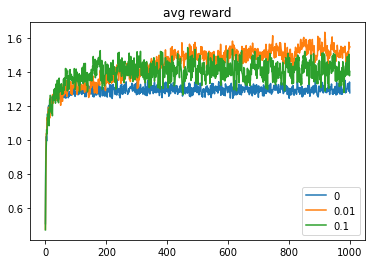

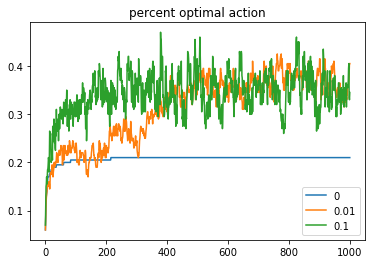

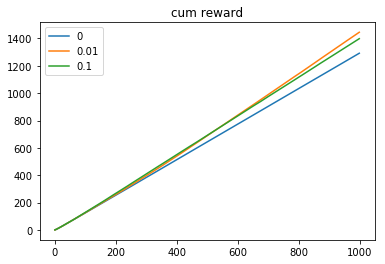

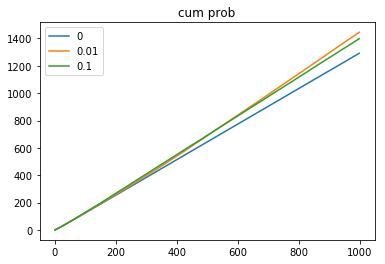

In [111]:
n_armed_bandit_greedy(200, 10, 1000, eps_array=[0, 0.01, 0.1])

In [83]:
def softmax(q_t, bandit, chosen_arm, tau, num_arms):
    acc = 0
    for arm in range(num_arms):
        acc += np.exp(q_t[bandit, arm]/tau)
    return np.exp(q_t[bandit, chosen_arm]/tau)/acc

In [106]:
def n_armed_bandit_softmax(num_bandits, num_arms, num_steps, sigma = 1.0, tau_array = [1]):

    # global initializations
    q_star_means = np.random.randn(num_bandits, num_arms)

    q_t0 = np.random.normal( q_star_means )

    avg_reward  = np.zeros((len(tau_array),num_steps))
    percent_optimal_action = np.zeros((len(tau_array),num_steps))
    cumulative_rewards = np.zeros((len(tau_array),num_steps))
    cumulative_probs = np.zeros((len(tau_array),num_steps))
    
    # set initial probabilities randomly
    probs = np.zeros(num_arms)
    
    
        
    q_t = np.zeros((q_t0.shape));  # <- initialize to zero draws per arm (no knowledge)
    q_n = np.ones(( num_bandits, num_arms )); # keep track of the number draws on each arm 
    q_s = q_t; # keep track of the SUM of the rewards to calculate average later via q_t = q_s./q_n
    all_rewards = np.zeros((num_bandits, num_steps)); # going to store each of the rewards here
    picked_max_action = np.zeros((num_bandits, num_steps));  # records whether best arm was chosen
    
    for tau_i, tau in enumerate(tau_array):
        # explore each of the bandits, all with n-arms
        for bandit in range(num_bandits): # pick a bandit
            for step in range(num_steps): # take a timestep

                # implement softmax
                # first find the softmax values for each action
                for chosen_arm in range(num_arms):
                    probs[chosen_arm] = softmax(q_t, bandit, chosen_arm, tau, num_arms)

                # select one arm with probability given by the softmax value
                arm = np.random.choice(range(num_arms), 1, p=probs)

    #                 # explore with probability eps
    #                 if np.random.uniform(0, 1) < eps:
    #                     arm = round(np.random.uniform(0, num_arms-1))
    #                 # greedily choose otherwise
    #                 else:
    #                     arm = np.argmax(q_t[bandit,:])

                # the best arm for this bandit from the given q_star_means
                best_arm = np.argmax(q_star_means[bandit, :])

                # record whether the best arm was chosen
                if arm == best_arm:
                    picked_max_action[bandit, step] = 1

                reward = q_star_means[bandit, arm] + sigma*np.random.uniform(0, 1)

                # make note of the reward
                all_rewards[bandit, step] = reward

                # add one to number of draws on this arm
                q_n[bandit, arm] += 1

                # add reward to sum of rewards
                q_s[bandit, arm] += reward

                # record average reward 
                q_t[bandit, arm] = q_s[bandit, arm]/q_n[bandit, arm]

        # find average reward over bandits for each time step 
        avg_reward[tau_i, :] = np.mean(all_rewards, axis=0)

        # find percentage of action choices that were optimal over bandits for each time step 
        percent_optimal_action[tau_i, :] = np.mean(picked_max_action, axis=0)

        # do a cumulative sum of rewards across time steps for each bandit
        cumsum_per_bandit = np.cumsum(all_rewards, axis=1)
        cumulative_rewards[tau_i] = np.mean(cumsum_per_bandit, axis= 0)

        # do a cumulative sum of rewards across time steps for each bandit
        cumsum_prob_per_bandit = np.cumsum(picked_max_action, axis=1)/np.cumsum(np.ones(picked_max_action.shape), axis = 1)
        cumulative_probs[tau_i] = np.mean(cumsum_prob_per_bandit, axis= 0)
    
    for tau_i, tau in enumerate(tau_array):
        plt.plot(np.arange(num_steps), avg_reward[tau_i, :])
    plt.title("avg reward")
    plt.legend(tau_array)
    plt.show()
    
    
    for tau_i, tau in enumerate(tau_array):
        plt.plot(np.arange(num_steps), percent_optimal_action[tau_i, :])
    plt.title("percent optimal action")
    plt.legend(tau_array)
    plt.show()
    
    for tau_i, tau in enumerate(tau_array):
        plt.plot(np.arange(num_steps), cumulative_rewards[tau_i, :])
    plt.title("cum reward")
    plt.legend(tau_array)
    plt.show()
    
    for tau_i, tau in enumerate(tau_array):
        plt.plot(np.arange(num_steps), cumulative_rewards[tau_i, :])
    plt.title("cum prob")
    plt.legend(tau_array)
    plt.show()

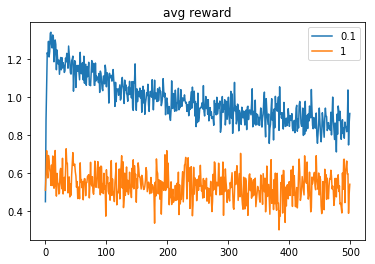

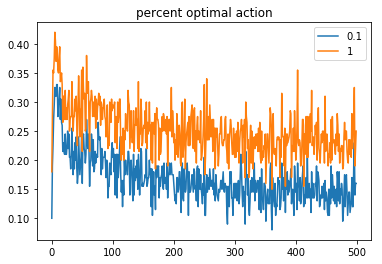

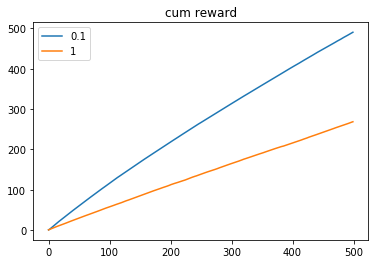

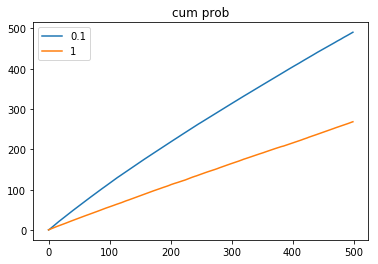

In [107]:
n_armed_bandit_softmax(200, 10, 500, tau_array = [0.1, 1])

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


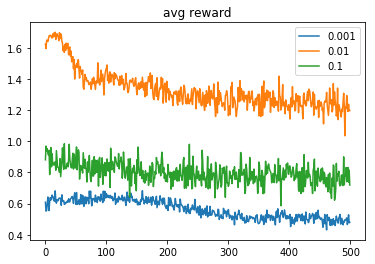

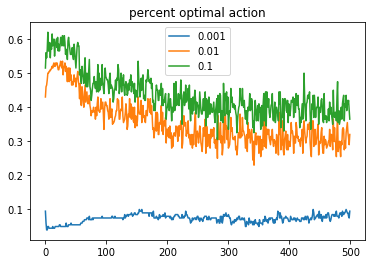

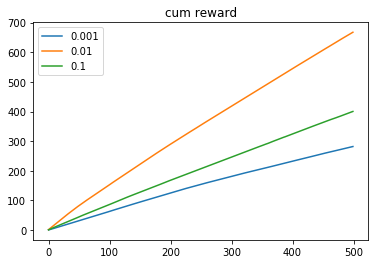

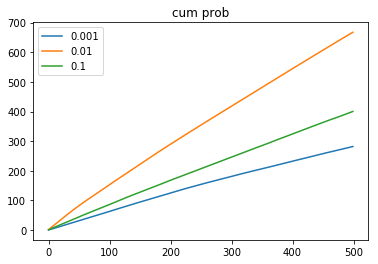

In [101]:
n_armed_bandit_softmax(200, 10, 500, tau_array = [0.001, 0.01, 0.1])